<a href="https://colab.research.google.com/github/dscho15/DeepLearning/blob/main/nn_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import copy

# Numpy
import numpy as np 

# Scipy
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R

# Matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Torch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T

In [30]:
data = loadmat('/content/drive/MyDrive/ForceTorque/nn_subsample.mat')

x = data['nn_subsample'][:,6:]
y = data['nn_subsample'][:,:6]

In [31]:
quat_list = []

for rotm in x:
  rotm = np.array(rotm).reshape(3, 3)
  quat_list.append(R.from_matrix(rotm).as_quat())

x = np.stack(quat_list)

In [32]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, x, y):
        self.x = torch.tensor(x.copy().astype(np.float32))
        self.y = torch.tensor(y.copy().astype(np.float32))

  def __len__(self):
        return x.shape[0]

  def __getitem__(self, index):
        return self.x[index].clone(), self.y[index].clone()

In [33]:
data_train = Dataset(x, y)
data_train, data_valid, data_test = torch.utils.data.random_split(data_train, (25000, 5000, x.shape[0] - 30000))


loader_train = torch.utils.data.DataLoader(data_train, batch_size = 256, num_workers=2, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size = 256, num_workers=2)
loader_test = torch.utils.data.DataLoader(data_test, batch_size = 256, num_workers=2)

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self):
      super(NeuralNetwork, self).__init__()
      self.model = nn.Sequential(
          
          nn.BatchNorm1d(4),
          nn.Linear(4, 16),
          nn.ReLU(),
          
          nn.BatchNorm1d(16),
          nn.Linear(16, 32),
          nn.ReLU(),

          nn.BatchNorm1d(32),
          nn.Linear(32, 16),
          nn.ReLU(),

          nn.BatchNorm1d(16),
          nn.Linear(16, 6),
      )

    def forward(self, x):
      return self.model(x)

In [35]:
all_losses = {}
best_loss = 10000000000000
best_model = None

In [36]:
device = torch.device('cuda')
model = NeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=2e-6)

train_losses = []
valid_losses = []

for epoch in tqdm(range(50)):

    model.train()

    epoch_losses = []
    correct, total = 0, 0

    for x, y in loader_train:
  
        x, y = x.to(device), y.to(device)
        
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        total += len(x)

    train_loss = np.mean(epoch_losses)


    # validation

    with torch.no_grad():

        model.eval()

        valid_losses_batch = []
        correct, total = 0, 0

        for x, y in loader_valid:

            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)

            total += len(x)
            valid_losses_batch.append(loss.item())
    
    valid_loss = np.mean(valid_losses_batch)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = copy.deepcopy(model), epoch

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

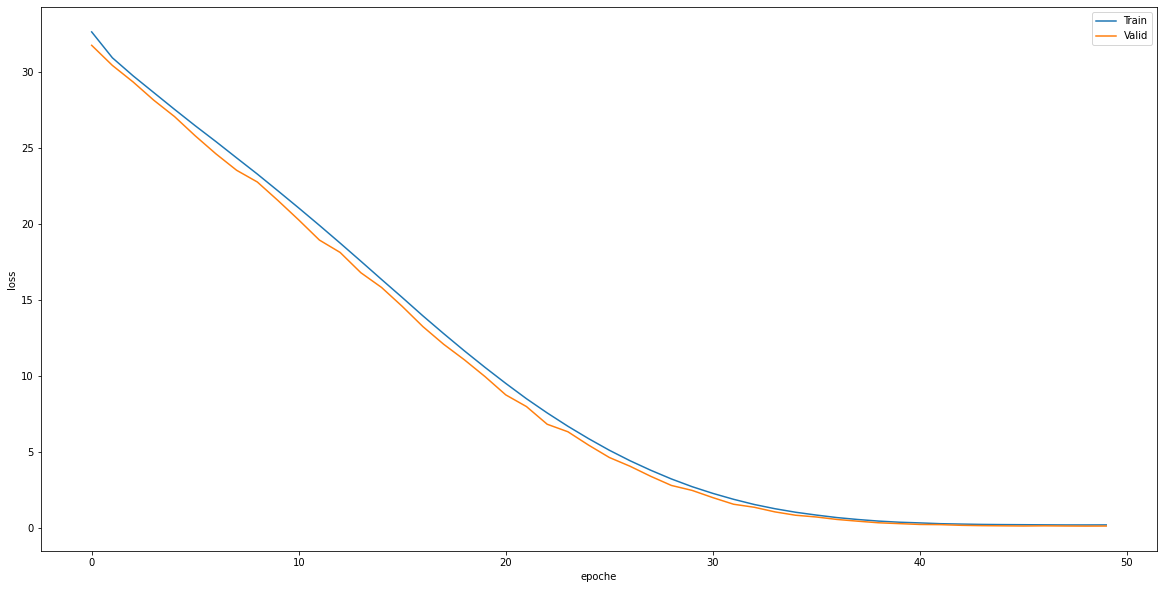

In [38]:
plt.figure(1, figsize=(20,10))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xlabel("epoche")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])

plt.show()

In [39]:
model = best_model[0]

with torch.no_grad():

    test_losses_batch = []
    total = 0
    model.eval()

    for x, y in loader_test:

      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = F.mse_loss(y_hat, y)

      total += len(x)
      test_losses_batch.append(loss.item())
    
test_loss = np.mean(test_losses_batch)

print("The test loss: %s"%(test_loss))

The test loss: 0.11965858138033322
